In this notebook I will be evaluating 2 techniques in Transfer Learning from VGG16 model: 
1. Freeze VGG16 feature extractor module
2. Apply differential learning rate - applying different learning rate to different layers of the model

 
>  Instead of unfreezing specific layers, it’s probably a better idea to use a differential learning rate, where the learning rate is determined on a per-layer basis. The bottom layers will then have a very low learning rate, as these generalise quite well, responding principally to edges, blobs and other trivial geometries, whereas the layers responding to more complex features will have a larger learning rate. In the past, the 2:4:6 rule (negative powers of 10) has worked quite well for me — using a learning rate of 10^-6 for the bottommost few layers, 10^-4 for the other transfer layers and 10^-2 for any additional layers we added. I have also heard others using 2:3:4:5:6 or 2:3:4 with different architectures. For ResNets and their derivatives, I have always felt more comfortable with 2:4:6 than 2:3:4, but I have absolutely no empirical evidence to back this up with.

Idea Reference: https://medium.com/starschema-blog/transfer-learning-the-dos-and-donts-165729d66625

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


In [ ]:
dftrain = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train.csv")
dftrain.head()

In [ ]:
dftrain.shape,dftrain.PatientID.nunique()

In [ ]:
dfss = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/sample_submission.csv")
dfss.head()

In [ ]:
dftrain[['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']].sum()
# .isnull().sum()

In [ ]:
dftrain = dftrain.sample(frac=1).reset_index(drop=True)

MultiLabel Stratified K Fold

In [ ]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=15)
for fold_, (train_, valid_) in enumerate(mskf.split(X=dftrain.values,y=dftrain[['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']].values)):
    dftrain.loc[valid_, 'fold'] = fold_

In [ ]:
dftrain.groupby("fold").sum()

In [ ]:
dftrain.shape

In [ ]:
dfan = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train_annotations.csv")
dfan.head()

In [ ]:
dfan.iloc[0,2]

In [ ]:
dfan.StudyInstanceUID.nunique(),dftrain.StudyInstanceUID.nunique(),dfan.shape,dfan.label.value_counts()

In [ ]:
dftrain.shape

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
# ../input/train.csv
img = cv2.imread("../input/ranzcr-clip-catheter-line-classification/train/"+dftrain.iloc[0,0]+".jpg")
plt.imshow(img)

In [ ]:
import torch.nn as nn
import torchvision


In [ ]:
import torch

In [ ]:
import torch
class PTModel(nn.Module):
    def __init__(self,pretrained=True,num_classes=11):
        super(PTModel,self).__init__()
        self.pretrained_model = torchvision.models.vgg16(pretrained=pretrained)
        self.pretrained_model.load_state_dict(torch.load("../input/vgg16-torchvision/vgg16-397923af.pth"))
        self.pretrained_model.classifier[-1] = nn.Linear(4096,num_classes,bias=True)
    
    def forward(self,x):
#         print(x.shape)
        output = self.pretrained_model(x)
#         print(output.shape)
        return output
model =  PTModel(False,11)
sample = torch.randn(2,3,512,512)
model(sample).shape
        

# ***Differential Learning Rate***


[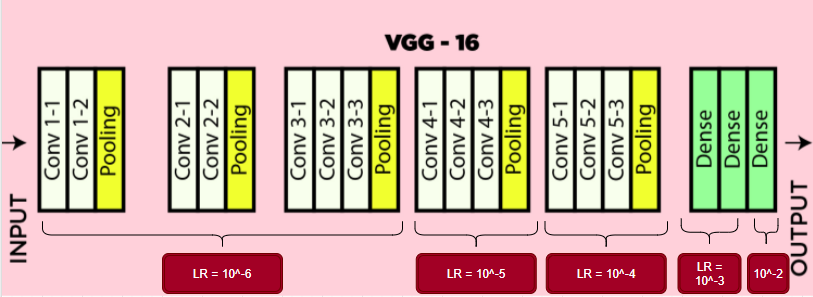](http://)

In [ ]:
DEVICE="cuda:0"
criterion = nn.BCEWithLogitsLoss().to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(
            [
                {"params":model.pretrained_model.features[:18].parameters(),"lr":1e-6},
                {"params":model.pretrained_model.features[18:25].parameters(),"lr":1e-5},
                {"params":model.pretrained_model.features[25:].parameters(),"lr":1e-4},
                {"params":model.pretrained_model.classifier[:2].parameters(),"lr":1e-3},
                {"params":model.pretrained_model.classifier[2:].parameters(),"lr":1e-2},
                
            ],
            lr=1e-3

)


In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations
TRAIN_PATH="../input/ranzcr-clip-catheter-line-classification/train"
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TARGETCOLS =['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
TRAIN_FOLDS = [0]
VAL_FOLDS = [1]
class RANZCRDataset(Dataset):
    def __init__(self, fold, df,targetcols,test=False,augmentations = None):
        if test==False:
            self.df = df[df["fold"].isin(fold)].copy().reset_index(drop=True)
        else:
            self.df = df[df["fold"].isin(fold)].copy().reset_index(drop=True)
        self.test = test
        self.aug = albumentations.Compose(
            [
                    albumentations.RandomScale(),
                    albumentations.OneOf([
                        albumentations.IAAAdditiveGaussianNoise(),
                        albumentations.GaussNoise(),
                        albumentations.GaussianBlur(),
                    ], p=0.3),
                    albumentations.OneOf([
                        albumentations.MotionBlur(p=.2),
                        albumentations.MedianBlur(blur_limit=3, p=.1),
                        albumentations.Blur(blur_limit=3, p=.1),
                    ], p=0.2),
                    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
                    albumentations.OneOf([
                        albumentations.OpticalDistortion(p=0.3),
                        albumentations.GridDistortion(p=.1),
                        albumentations.IAAPiecewiseAffine(p=0.3),
                    ], p=0.2),
                    albumentations.OneOf([
                        albumentations.CLAHE(clip_limit=2),
                        albumentations.IAASharpen(),
                        albumentations.IAAEmboss(),
                        albumentations.RandomContrast(),
                        albumentations.RandomBrightness(),
                    ], p=0.3),
                albumentations.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, p=1),
                albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, always_apply=True)
            ]
        )
        if self.test:
            self.aug = albumentations.Compose([albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, always_apply=True)])
        self.targetcols = targetcols
            
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,indx):
        selected_series = self.df.loc[indx]
        fname = os.path.join(TRAIN_PATH,selected_series["StudyInstanceUID"]+".jpg")
        image = Image.open(fname)
        image = image.convert("RGB")
        image = image.resize((IMAGE_HEIGHT,IMAGE_WIDTH),resample=Image.BILINEAR)
#         print(image.size)
        
        image = np.array(image)
        image = self.aug(image=image)["image"]
        
        image = np.transpose(image,(2,0,1)).astype(np.float32)
#         print(image.shape)
#         print()
        if self.test==False:
            targets = selected_series[self.targetcols].values.astype('int')
            return {
                "image": torch.tensor(image,dtype=torch.float,device=DEVICE),
                "targets": torch.tensor(targets,dtype=torch.float,device=DEVICE)
            }
        else:
            targets = selected_series[self.targetcols].values.astype('int')
            return {
                "image": torch.tensor(image,dtype=torch.float,device=DEVICE),
                "targets": torch.tensor(targets,dtype=torch.float,device=DEVICE)
            }


        
        

In [ ]:

dataset = RANZCRDataset(fold=TRAIN_FOLDS, df=dftrain,targetcols=TARGETCOLS,test=False)
dataloader = DataLoader(dataset, batch_size=10,
                        shuffle=True, num_workers=0)
eval_dataloader = DataLoader(RANZCRDataset(fold=VAL_FOLDS, df=dftrain,targetcols=TARGETCOLS,test=True), batch_size=10,
                        shuffle=False, num_workers=0)


In [ ]:
from tqdm import tqdm
EPOCHS = 10
model.to(DEVICE)
losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch in tqdm(dataloader,total = len(dataloader)):
        model.zero_grad()
        images = batch["image"]
        targets = batch["targets"]
        outputs = model(images)
#         print(targets.shape,outputs.shape,images.shape)
        loss = criterion(outputs,targets)
        
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
#         break
        
    epoch_loss = epoch_loss/len(dataloader)
    
    losses.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        val_loss=0
        for batch in tqdm(eval_dataloader,total=len(eval_dataloader)):
            images = batch["image"]
            targets = batch["targets"]
            outputs = model(images)
            loss = criterion(outputs,targets)
            val_loss+=loss.item()
#             break
        val_loss = val_loss/len(eval_dataloader)
        val_losses.append(val_loss)
        
    print(f"LOGGING EPOCH {epoch} TRAIN_LOSS {epoch_loss} VAL_LOSS {val_loss}")
            


In [ ]:
history = pd.DataFrame({"train_loss":losses,"val_loss":val_losses})
history.plot()

# ***Frozen Feature Extractor Layers***

[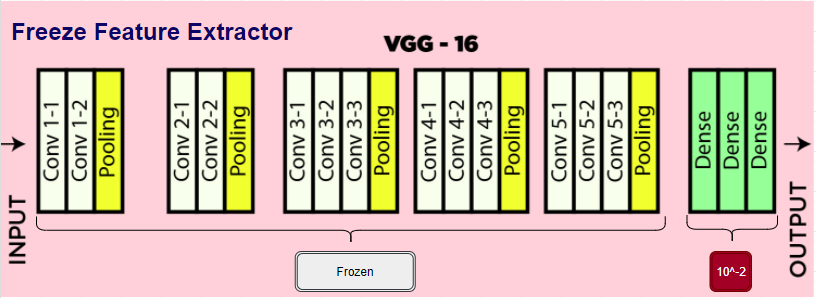](http://)# 

In [ ]:
model =  PTModel(False,11)
model.train()
for param in model.parameters():
    param.requires_grad = False
for param in model.pretrained_model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.pretrained_model.classifier.parameters(),lr=1e-2)

In [ ]:

model.to(DEVICE)
losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch in tqdm(dataloader,total = len(dataloader)):
        model.zero_grad()
        images = batch["image"]
        targets = batch["targets"]
        outputs = model(images)
#         print(targets.shape,outputs.shape,images.shape)
        loss = criterion(outputs,targets)
        
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
#         break
        
    epoch_loss = epoch_loss/len(dataloader)
    
    losses.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        val_loss=0
        for batch in tqdm(eval_dataloader,total=len(eval_dataloader)):
            images = batch["image"]
            targets = batch["targets"]
            outputs = model(images)
            loss = criterion(outputs,targets)
            val_loss+=loss.item()
#             break
        val_loss = val_loss/len(eval_dataloader)
        val_losses.append(val_loss)
        
    print(f"LOGGING EPOCH {epoch} TRAIN_LOSS {epoch_loss} VAL_LOSS {val_loss}")

In [ ]:
history = pd.DataFrame({"train_loss":losses,"val_loss":val_losses})
history.plot()

In [ ]:
# import glob
# test_files = glob.glob("../input/ranzcr-clip-catheter-line-classification/test/*.jpg")
# class InferenceDataset(Dataset):
#     def __init__(self,test_files):
#         self.files = test_files
#         self.aug = albumentations.Compose([albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, always_apply=True)])
        
#     def __len__(self):
#         return len(self.files)
#     def __getitem__(self,indx):
#         fname = self.files[indx]
#         image = Image.open(fname)
#         image = image.convert("RGB")
#         image = image.resize((IMAGE_HEIGHT,IMAGE_WIDTH),resample=Image.BILINEAR)
#         image = np.array(image)
#         image = self.aug(image=image)["image"]
#         image = np.transpose(image,(2,0,1)).astype(np.float32)
#         return {
#             "image": torch.tensor(image,dtype=torch.float,device=DEVICE),
#             "StudyInstanceUID": fname.strip(".jpg").split("/")[-1]
#         }
# inference_dataloader = DataLoader(InferenceDataset(test_files), batch_size=10,
#                         shuffle=False, num_workers=0)  


In [ ]:
# model.eval()
# subdf = pd.DataFrame()

# with torch.no_grad():
#     val_loss=0
#     for batch in tqdm(inference_dataloader,total=len(inference_dataloader)):
#         images = batch["image"]
#         outputs = model(images).detach().cpu().numpy()
#         ids = batch["StudyInstanceUID"]
#         tempdf = pd.DataFrame(outputs)
#         tempdf.columns = TARGETCOLS
#         tempdf["StudyInstanceUID"] = ids
#         if subdf.empty:
#             subdf = tempdf
#         else:
#             subdf = pd.concat([subdf,tempdf],ignore_index=True)
            
        


In [ ]:
# subdf = subdf[["StudyInstanceUID"]+TARGETCOLS]
# subdf.to_csv("submission.csv")
# # subdf
# history.to_csv("history.csv")

In [ ]:
# pretrained_model